In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy.linalg import inv
from sklearn.svm import SVR

In [2]:
df_jpm = pd.read_csv('df_jpm.csv')

In [3]:
df_jpm.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MktRF,SMB,HML,RF,RMW,CMA,SMB_5,yest_close,stock_return,log_return
0,2016-05-18,61.700001,64.169998,61.689999,64.040001,57.172466,24007100,0.10,0.10,0.83,0.001,-1.34,-0.65,0.14,55.047691,0.038599,0.000000
1,2016-05-19,63.529999,64.220001,62.900002,63.389999,56.592175,16076200,-0.33,-0.32,-0.30,0.001,0.39,-0.01,-0.31,57.172466,-0.010150,-0.010202
2,2016-05-20,63.860001,64.190002,63.369999,63.509998,56.699303,11862000,0.75,0.90,-0.30,0.001,-0.39,-0.38,0.84,56.592175,0.001893,0.001891
3,2016-05-23,63.450001,63.869999,63.160000,63.459999,56.654667,9347500,-0.18,0.26,-0.32,0.001,-0.21,0.08,0.24,56.699303,-0.000787,-0.000788
4,2016-05-24,63.939999,64.769997,63.810001,64.540001,57.618855,13839400,1.43,0.68,-0.34,0.001,-0.10,-0.39,0.61,56.654667,0.017019,0.016875


In [4]:
df_jpm = df_jpm[df_jpm.Date > '2016-05-17']
df_jpm = df_jpm[df_jpm.Date < '2020-01-06']

In [5]:
df_jpm.shape

(914, 17)

In [6]:
N = df_jpm.shape[0]
T = 61 
window = 60


In [7]:
Y = df_jpm['stock_return'][-(N-(T+1)):].values
Y_test = df_jpm['stock_return']
Y_test = Y_test[685:852]

In [8]:
Y.shape

(852,)

In [38]:
Y_test.shape

(167,)

    1. Fama French 3 Factors

In [9]:
def fama_french_train(X, Y):
    invXTX = np.linalg.inv(X.transpose()@X)
    beta_hat = invXTX@X.transpose() @ Y
    y_hat = X @ beta_hat
    return beta_hat, y_hat


In [10]:
y_test = df_jpm.stock_return[0:852]
def fama_french_3_factor(num_boot):
    yhat_ff3 = np.zeros(N - (T + 1))
    print()
    for t in range(T + 1, N):
        # training data
        # Columns MkrRF, SMF and HML are the independent variables used
        X_train = df_jpm[['MktRF','SMB','HML']][t - window:t - 1]  
        X_train = np.column_stack([np.ones((len(X_train), 1)), X_train])
        # Column stock_return is the depended variable and that is the one which we are trying to predict
        Y_train = df_jpm['stock_return'][t - window:t - 1].values
        # Predictions for each day
        X_pred = df_jpm[['MktRF','SMB','HML']][t - 1:t]
        X_pred = np.column_stack([np.ones((len(X_pred), 1)), X_pred])

        yhat_train = fama_french_train(X_train, Y_train)[1]
        res_train = Y_train - yhat_train
        y_pred_all = np.zeros(num_boot)
        # bootstrap 
        for i in range(0, num_boot):
            err = np.random.choice(res_train, (window - 1,), replace=True)
            y_bstr = yhat_train + err
            beta_bstr = fama_french_train(X_train, y_bstr)[0]
            y_pred_bstr = X_pred @ beta_bstr
            y_pred_all[i] = y_pred_bstr
        # Mean of all predictions
        y_pred_ff3 = y_pred_all.mean()  
        yhat_ff3[t - (T + 1)] = y_pred_ff3 
    # Calculating the rmse
    mse_ff3 = mean_squared_error(Y,yhat_ff3)
    rmse_ff3 = np.sqrt(mse_ff3)
    
    print('RMSE--------',rmse_ff3)
    
    return yhat_ff3, rmse_ff3

In [11]:
#RMSE with 150 bootstrap
y_pred_ff3,rmse_ff3 = fama_french_3_factor(150)


RMSE-------- 0.015858564161511258


In [41]:
#RMSE with 50 bootstrap
#y_pred_ff3,rmse_ff3 = fama_french_3_factor()


0.015863688738657837


In [310]:
y_pred_ff3.shape

(852,)

In [12]:
y_pred_ff3 = pd.DataFrame(data=y_pred_ff3,columns=['Prediction'])

In [13]:
y_pred_ff3.shape

(852, 1)

In [14]:
y_act_ff3 = Y
y_test_ff3 = pd.DataFrame(data=y_act_ff3,columns=['Actual'])
y_test_ff3.shape

(852, 1)

In [15]:
Y_new_ff3 = df_jpm['Date'][0:851]

In [16]:
Y_new_ff3 = pd.DataFrame(data=Y_new_ff3,columns=['Date'])

In [17]:
Y_new_ff3['Pred'] = y_pred_ff3['Prediction']
Y_new_ff3['Act'] = y_test_ff3['Actual']

In [18]:
Y_new_ff3.head()

,Date,Pred,Act
0,2016-05-18,0.006704,-0.000152
1,2016-05-19,-0.004063,0.002739
2,2016-05-20,0.004211,0.000911
3,2016-05-23,0.006301,-0.001365
4,2016-05-24,-0.003611,-0.000911


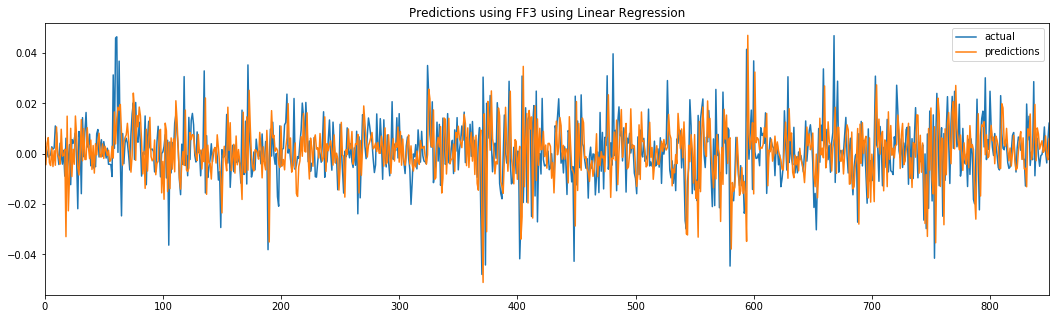

In [111]:
plot_df_ff3 = pd.DataFrame({"actual": Y_new_ff3['Act'], "predictions": Y_new_ff3['Pred']})
plot_df_ff3.plot(figsize=(18, 5), title='Predictions using FF3 using Linear Regression')
# plt.plot(Y_new['Act'], label = 'y_new')
# plt.plot(Y_new['Pred'], label = 'y_pred')



    2. Fama French 5 factors

In [19]:
y_test = df_jpm.stock_return[0:852]
def fama_french_5_factor(num_boot):
    yhat_ff5 = np.zeros(N - (T + 1))
    print()
    for t in range(T + 1, N):
        # training data
        # Columns MkrRF, SMF and HML RMW CMA are the independent variables used
        X_train = df_jpm[['MktRF','SMB_5','HML','RMW','CMA']][t - window:t - 1]  
        X_train = np.column_stack([np.ones((len(X_train), 1)), X_train])
        # Column stock_return is the depended variable and that is the one which we are trying to predict
        Y_train = df_jpm['stock_return'][t - window:t - 1].values
        # Predictions for each day
        X_pred = df_jpm[['MktRF','SMB_5','HML','RMW','CMA']][t - 1:t]
        X_pred = np.column_stack([np.ones((len(X_pred), 1)), X_pred])

        yhat_train = fama_french_train(X_train, Y_train)[1]
        res_train = Y_train - yhat_train
        y_pred_all = np.zeros(num_boot)
        # bootstrap 
        for i in range(0, num_boot):
            err = np.random.choice(res_train, (window - 1,), replace=True)
            y_bstr = yhat_train + err
            beta_bstr = fama_french_train(X_train, y_bstr)[0]
            y_pred_bstr = X_pred @ beta_bstr
            y_pred_all[i] = y_pred_bstr
        # Mean of all predictions
        y_pred_ff5 = y_pred_all.mean()  
        yhat_ff5[t - (T + 1)] = y_pred_ff5 
    # Calculating the rmse
    mse_ff5 = mean_squared_error(Y,yhat_ff5)
    rmse_ff5 = np.sqrt(mse_ff5)
    
    print('RMSE--------',rmse_ff5)
    
    return yhat_ff5, rmse_ff5

In [20]:
#RMSE with 100 bootstrap
y_pred_ff5,rmse_ff5 = fama_french_5_factor(100)


RMSE-------- 0.016207572889253688


In [128]:
#RMSE with 50 bootstrap
y_pred_ff5,rmse_ff5 = fama_french_5_factor(50)


RMSE-------- 0.016229539566905683


In [130]:
y_pred_ff5.shape

(852,)

In [21]:
y_pred_ff5 = pd.DataFrame(data=y_pred_ff5,columns=['Prediction'])

In [22]:
y_pred_ff5.shape

(852, 1)

In [23]:
y_act_ff5 = Y
y_test_ff5 = pd.DataFrame(data=y_act_ff5,columns=['Actual'])
y_test_ff5.shape

(852, 1)

In [24]:
Y_new_ff5 = df_jpm['Date'][0:851]

In [25]:
Y_new_ff5 = pd.DataFrame(data=Y_new_ff5,columns=['Date'])

In [26]:
Y_new_ff5['Pred'] = y_pred_ff5['Prediction']
Y_new_ff5['Act'] = y_test_ff5['Actual']

In [27]:
Y_new_ff5.head()

,Date,Pred,Act
0,2016-05-18,0.005896,-0.000152
1,2016-05-19,-0.003066,0.002739
2,2016-05-20,0.003547,0.000911
3,2016-05-23,0.007178,-0.001365
4,2016-05-24,-0.003235,-0.000911


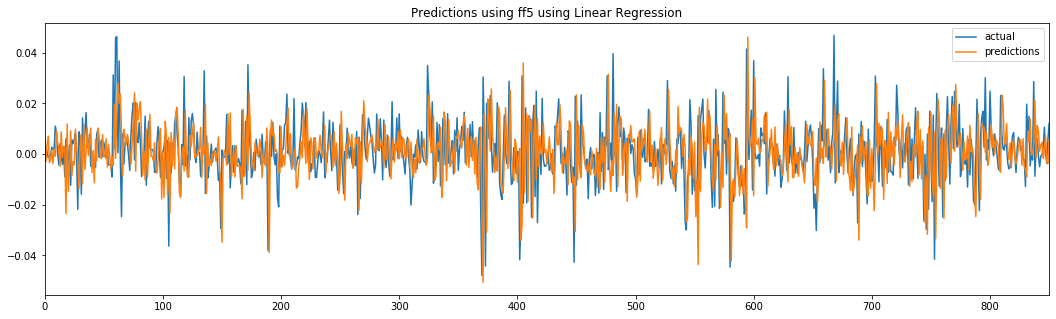

In [138]:
plot_df_ff5 = pd.DataFrame({"actual": Y_new_ff5['Act'], "predictions": Y_new_ff5['Pred']})
plot_df_ff5.plot(figsize=(18, 5), title='Predictions using ff5 using Linear Regression')



In [375]:
df_jpm.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MktRF,SMB,HML,RF,RMW,CMA,SMB_5,yest_close,stock_return,log_return
0,2016-05-18,61.700001,64.169998,61.689999,64.040001,57.172466,24007100,0.10,0.10,0.83,0.001,-1.34,-0.65,0.14,55.047691,0.038599,0.000000
1,2016-05-19,63.529999,64.220001,62.900002,63.389999,56.592175,16076200,-0.33,-0.32,-0.30,0.001,0.39,-0.01,-0.31,57.172466,-0.010150,-0.010202
2,2016-05-20,63.860001,64.190002,63.369999,63.509998,56.699303,11862000,0.75,0.90,-0.30,0.001,-0.39,-0.38,0.84,56.592175,0.001893,0.001891
3,2016-05-23,63.450001,63.869999,63.160000,63.459999,56.654667,9347500,-0.18,0.26,-0.32,0.001,-0.21,0.08,0.24,56.699303,-0.000787,-0.000788
4,2016-05-24,63.939999,64.769997,63.810001,64.540001,57.618855,13839400,1.43,0.68,-0.34,0.001,-0.10,-0.39,0.61,56.654667,0.017019,0.016875


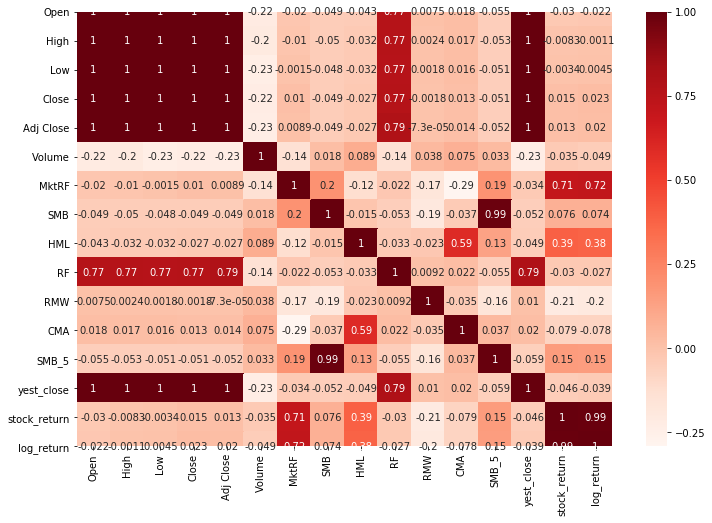

In [383]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,8))
cor = df_jpm.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [409]:
#Correlation with output variable
cor_target = abs(cor["stock_return"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.04]

relevant_features = relevant_features.reset_index()

In [413]:
relevant_features.sort_values(by='stock_return',ascending=False)

,index,stock_return
7,stock_return,1.000000
8,log_return,0.992087
0,MktRF,0.711980
2,HML,0.387596
3,RMW,0.211055
5,SMB_5,0.153136
4,CMA,0.078769
1,SMB,0.075744
6,yest_close,0.046115


In [377]:
df_jpm.corr()

,Open,High,Low,Close,Adj Close,Volume,MktRF,SMB,HML,RF,RMW,CMA,SMB_5,yest_close,stock_return,log_return
Open,1.000000,0.999303,0.999074,0.998380,0.995427,-0.216142,-0.019978,-0.049254,-0.042980,0.769391,0.007500,0.018444,-0.055011,0.996300,-0.029706,-0.021980
High,0.999303,1.000000,0.998947,0.999207,0.996257,-0.204871,-0.010460,-0.049539,-0.031537,0.772395,0.002357,0.017188,-0.053121,0.995806,-0.008318,-0.001125
Low,0.999074,0.998947,1.000000,0.999307,0.996506,-0.233502,-0.001467,-0.047843,-0.031891,0.766683,0.001805,0.015646,-0.051290,0.995709,-0.003391,0.004528
Close,0.998380,0.999207,0.999307,1.000000,0.997140,-0.222283,0.010416,-0.048892,-0.026637,0.769210,-0.001783,0.012547,-0.051186,0.995217,0.015059,0.022520
Adj Close,0.995427,0.996257,0.996506,0.997140,1.000000,-0.231380,0.008904,-0.049465,-0.027023,0.791950,-0.000073,0.014202,-0.051716,0.998166,0.013190,0.020160
Volume,-0.216142,-0.204871,-0.233502,-0.222283,-0.231380,1.000000,-0.140289,0.017588,0.089412,-0.137480,0.038415,0.075263,0.032516,-0.227929,-0.035261,-0.049130
MktRF,-0.019978,-0.010460,-0.001467,0.010416,0.008904,-0.140289,1.000000,0.195016,-0.123464,-0.022261,-0.173266,-0.292847,0.187896,-0.034156,0.711980,0.717201
SMB,-0.049254,-0.049539,-0.047843,-0.048892,-0.049465,0.017588,0.195016,1.000000,-0.014850,-0.052528,-0.194778,-0.037227,0.985583,-0.051816,0.075744,0.074219
HML,-0.042980,-0.031537,-0.031891,-0.026637,-0.027023,0.089412,-0.123464,-0.014850,1.000000,-0.033295,-0.022918,0.594459,0.131315,-0.049165,0.387596,0.378433
RF,0.769391,0.772395,0.766683,0.769210,0.791950,-0.137480,-0.022261,-0.052528,-0.033295,1.000000,0.009228,0.021662,-0.055197,0.793103,-0.030219,-0.026661


In [445]:
y_train.shape

(800, 1)

In [446]:
y_test.shape

(114, 1)

In [447]:
X_test.shape

(114, 5)

In [451]:
df_jpm.shape

(914, 17)

In [463]:
rmse_svm = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_svm

0.01741804772445823

In [58]:
from sklearn.svm import SVR  
def svm_train(X_train, Y_train, X_pred):  
    svr_model = SVR(kernel='rbf', gamma=0.0005)
    result = svr_model.fit(X_train, Y_train)
 
    y_hat = result.predict(X_train)  
    y_pred = result.predict(X_pred)
    
    return y_hat, y_pred


In [99]:

def svm_bstr(num_boot):
    yhat_svm = np.zeros(N-(T+1))
    for t in range(T+1, N):    
        X_train = df_jpm[['MktRF','HML','RMW','SMB_5']][t-window:t-1] 
        X_train = np.column_stack([np.ones((len(X_train),1)),X_train])
        X_pred = df_jpm[['MktRF','HML','RMW','SMB_5']][t-1:t]
        X_pred = np.column_stack([np.ones((len(X_pred),1)),X_pred])
        Y_train = df_jpm['stock_return'][t-window:t-1].values    
        yhat_train = svm_train(X_train, Y_train, X_pred)[0] 
        res_train =  Y_train - yhat_train        
        y_pred_all = np.zeros(num_boot)
        # bootstrap method
        for i in range(0, num_boot):
            err = np.random.choice(res_train, (window-1, ), replace=True)
            y_bstr = yhat_train + err                        
            y_pred_bstr = svm_train(X_train, y_bstr, X_pred)[1]
            y_pred_all[i]=y_pred_bstr
        # mean of all bootstrap predictions
        y_pred_svm = y_pred_all.mean() 
        yhat_svm[t-(T+1)]=y_pred_svm        
    rmse_svm=np.sqrt(np.mean((Y-yhat_svm)**2))
    print('RMSE----',rmse_svm)
    return yhat_svm, rmse_svm


In [101]:
yhat_svm,rmse_svm = svm_bstr(100)

RMSE---- 0.013243093122682275


In [66]:
df_comb = pd.DataFrame()
df_comb['Date'] = df_jpm['Date'][0:851].tolist()
df_comb['stock_return'] = df_jpm['stock_return'][0:851].values
df_comb['FF3'] = y_pred_ff3[0:851]
df_comb['FF5'] = y_pred_ff5[0:851]
df_comb['SVM'] = yhat_svm[0:851].tolist()

In [65]:
df_comb.head()

,Date,stock_return,FF3,FF5,SVM
0,2016-05-18,0.038599,0.006704,0.005896,-0.018162
1,2016-05-19,-0.010150,-0.004063,-0.003066,-0.000118
2,2016-05-20,0.001893,0.004211,0.003547,-0.018162
3,2016-05-23,-0.000787,0.006301,0.007178,-0.018162
4,2016-05-24,0.017019,-0.003611,-0.003235,-0.018162


In [125]:
Y_comb = np.zeros(df_comb.shape[0])
temp = []
pred_stock_return = []
for t in range(0, len(df_comb)):
    if min(abs(df_comb['FF3'][t]-df_comb['stock_return'][t]),abs(df_comb['FF5'][t]-df_comb['stock_return'][t]),abs(df_comb['SVM'][t]-df_comb['stock_return'][t])) == abs(df_comb['FF3'][t]-df_comb['stock_return'][t]):
        Y_comb[t] = df_comb['FF3'][t]
        temp.append('FF3')
    elif min(abs(df_comb['FF3'][t]-df_comb['stock_return'][t]),abs(df_comb['FF5'][t]-df_comb['stock_return'][t]),abs(df_comb['SVM'][t]-df_comb['stock_return'][t]))== abs(df_comb['FF5'][t]-df_comb['stock_return'][t]):
        Y_comb[t] = df_comb['FF5'][t]
        temp.append('FF5')
    else:
        Y_comb[t] = df_comb['SVM'][t]
        temp.append('SVM')

df_comb['model'] = temp



In [126]:
df_comb.head(10)

,Date,stock_return,FF3,FF5,SVM,model,Predicted_stock_return
0,2016-05-18,0.038599,0.006704,0.005896,-0.018162,FF3,0.006704
1,2016-05-19,-0.010150,-0.004063,-0.003066,-0.000118,FF3,-0.000118
2,2016-05-20,0.001893,0.004211,0.003547,-0.018162,FF5,0.004211
3,2016-05-23,-0.000787,0.006301,0.007178,-0.018162,FF3,0.007178
4,2016-05-24,0.017019,-0.003611,-0.003235,-0.018162,FF5,-0.003235
5,2016-05-25,0.015184,-0.004634,-0.002308,-0.018162,FF5,-0.002308
6,2016-05-26,-0.007479,0.002285,0.001547,-0.003219,SVM,0.002285
7,2016-05-27,0.006151,-0.005259,-0.003840,-0.018162,FF5,-0.003840
8,2016-05-31,-0.002446,0.001442,0.001669,0.002620,FF3,0.002620
9,2016-06-01,0.006435,-0.004432,-0.000829,-0.018162,FF5,-0.000829


In [128]:
df_comb['Predicted_stock_return_maximum'] = df_comb[['FF3','FF5','SVM']].max(axis=1)
df_comb['Predicted_stock_return_minimum'] = df_comb[['FF3','FF5','SVM']].min(axis=1)
# df_comb['Predicted_stock_return'] = max(df_comb['FF3'],max(df_comb['FF5'],df_comb['SVM']))

In [129]:
df_comb.head(10)

,Date,stock_return,FF3,FF5,SVM,model,Predicted_stock_return,Predicted_stock_return_maximum,Predicted_stock_return_minimum
0,2016-05-18,0.038599,0.006704,0.005896,-0.018162,FF3,0.006704,0.006704,-0.018162
1,2016-05-19,-0.010150,-0.004063,-0.003066,-0.000118,FF3,-0.000118,-0.000118,-0.004063
2,2016-05-20,0.001893,0.004211,0.003547,-0.018162,FF5,0.004211,0.004211,-0.018162
3,2016-05-23,-0.000787,0.006301,0.007178,-0.018162,FF3,0.007178,0.007178,-0.018162
4,2016-05-24,0.017019,-0.003611,-0.003235,-0.018162,FF5,-0.003235,-0.003235,-0.018162
5,2016-05-25,0.015184,-0.004634,-0.002308,-0.018162,FF5,-0.002308,-0.002308,-0.018162
6,2016-05-26,-0.007479,0.002285,0.001547,-0.003219,SVM,0.002285,0.002285,-0.003219
7,2016-05-27,0.006151,-0.005259,-0.003840,-0.018162,FF5,-0.003840,-0.003840,-0.018162
8,2016-05-31,-0.002446,0.001442,0.001669,0.002620,FF3,0.002620,0.002620,0.001442
9,2016-06-01,0.006435,-0.004432,-0.000829,-0.018162,FF5,-0.000829,-0.000829,-0.018162


In [70]:
Y_new_ff5 = pd.DataFrame(data=Y_new_ff5,columns=['Date'])

In [71]:
df_jpm_date = df_jpm['Date'][0:832]
df_jpm_date = pd.DataFrame(data=df_jpm_date,columns=['Date'])

stock = df_jpm['stock_return'][0:832]
stock = pd.DataFrame(data=stock,columns=['stock_return'])

df_jpm_date['Date'] = df_jpm_date['Date']
df_jpm_date['stock_return'] = stock['stock_return']


In [72]:

df_comb_date = df_comb['Date'][500:]
df_comb_date = pd.DataFrame(data=df_comb_date,columns=['Date'])

ff3 = df_comb['FF3'][500:]
ff3 = pd.DataFrame(data=ff3,columns=['FF3'])

ff5 = df_comb['FF5'][500:]
ff5 = pd.DataFrame(data=ff5,columns=['FF5'])

svm = df_comb['SVM'][500:]
svm = pd.DataFrame(data=svm,columns=['SVM'])

df_comb_date['SVM'] = svm['SVM']

df_comb_date['FF3'] = ff3['FF3']
df_comb_date['FF5'] = ff5['FF5']

In [73]:
df_comb_date.head()

,Date,SVM,FF3,FF5
500,2018-05-14,-0.001534,-0.005620,-0.002211
501,2018-05-15,-0.009688,-0.013130,-0.017255
502,2018-05-16,-0.009688,-0.008137,-0.010387
503,2018-05-17,0.011018,0.011237,0.008760
504,2018-05-18,0.011018,-0.010470,-0.010734


In [364]:
df_jpm_date.head()

,Date,stock_return
0,2016-05-18,0.038599
1,2016-05-19,-0.010150
2,2016-05-20,0.001893
3,2016-05-23,-0.000787
4,2016-05-24,0.017019


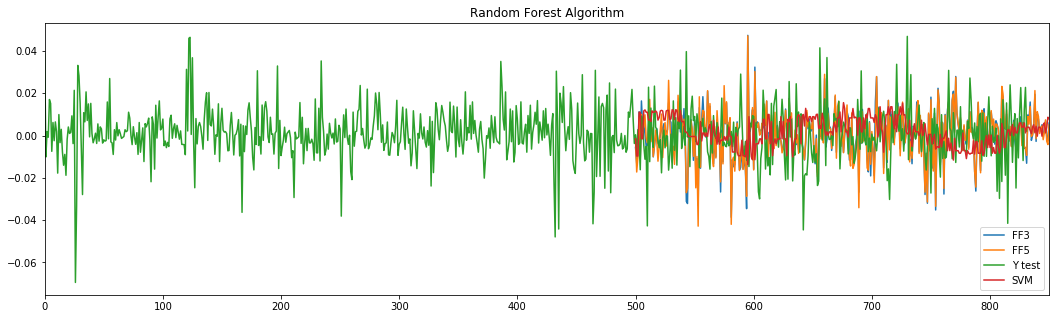

In [79]:
plot_df_kalman_filter = pd.DataFrame({"FF3": df_comb_date['FF3'], "FF5": df_comb_date['FF5'],"Y test": df_jpm_date['stock_return'],"SVM": df_comb_date['SVM']})
plot_df_kalman_filter.plot(figsize=(18, 5), title='Random Forest Algorithm')


In [103]:
rmse_random_forest = np.sqrt(np.mean((Y-Y_comb[t])**2))


In [104]:
rmse_random_forest

0.012630059742643779

In [112]:
df_jpm['price'] = df_jpm['stock_return'].cumsum() 

In [114]:
df_jpm

,Date,Open,High,Low,Close,Adj Close,Volume,MktRF,SMB,HML,RF,RMW,CMA,SMB_5,yest_close,stock_return,log_return,price
0,2016-05-18,61.700001,64.169998,61.689999,64.040001,57.172466,24007100,0.10,0.10,0.83,0.001,-1.34,-0.65,0.14,55.047691,0.038599,0.000000,0.038599
1,2016-05-19,63.529999,64.220001,62.900002,63.389999,56.592175,16076200,-0.33,-0.32,-0.30,0.001,0.39,-0.01,-0.31,57.172466,-0.010150,-0.010202,0.028449
2,2016-05-20,63.860001,64.190002,63.369999,63.509998,56.699303,11862000,0.75,0.90,-0.30,0.001,-0.39,-0.38,0.84,56.592175,0.001893,0.001891,0.030342
3,2016-05-23,63.450001,63.869999,63.160000,63.459999,56.654667,9347500,-0.18,0.26,-0.32,0.001,-0.21,0.08,0.24,56.699303,-0.000787,-0.000788,0.029555
4,2016-05-24,63.939999,64.769997,63.810001,64.540001,57.618855,13839400,1.43,0.68,-0.34,0.001,-0.10,-0.39,0.61,56.654667,0.017019,0.016875,0.046573
5,2016-05-25,64.940002,66.199997,64.919998,65.519997,58.493767,18935200,0.72,-0.21,0.57,0.001,0.21,-0.10,-0.13,57.618855,0.015184,0.015070,0.061758
6,2016-05-26,65.570000,65.580002,64.910004,65.029999,58.056301,9428400,-0.04,-0.09,-0.51,0.001,0.17,-0.22,-0.16,58.493767,-0.007479,-0.007507,0.054279
7,2016-05-27,65.209999,65.459999,65.050003,65.430000,58.413418,10116000,0.49,0.33,-0.22,0.001,-0.06,-0.09,0.36,58.056301,0.006151,0.006132,0.060430
8,2016-05-31,65.730003,65.820000,64.959999,65.269997,58.270561,15139400,-0.01,0.50,-0.36,0.001,-0.17,-0.33,0.45,58.413418,-0.002446,-0.002448,0.057985
9,2016-06-01,64.760002,65.919998,64.260002,65.690002,58.645523,14031000,0.20,0.65,-0.25,0.001,-0.26,0.08,0.64,58.270561,0.006435,0.006414,0.064419


In [ ]:
# We know only columns [MktRF	SMB	HML]

In [139]:
# Trading Strategy
df_comb[14:17]

,Date,stock_return,FF3,FF5,SVM,model,Predicted_stock_return_maximum,Predicted_stock_return_minimum
14,2016-06-08,0.002920,0.009717,0.008858,-0.018162,FF5,0.009717,-0.018162
15,2016-06-09,-0.007663,-0.000877,-0.000638,0.000913,FF3,0.000913,-0.000877
16,2016-06-10,-0.014054,-0.000601,0.003137,-0.018162,SVM,0.003137,-0.018162


In [117]:
df_jpm['predicted_close_price']= (df_jpm['stock_return']+1)*df_jpm['yest_close']

In [140]:
df_jpm.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MktRF,SMB,HML,RF,RMW,CMA,SMB_5,yest_close,stock_return,log_return,price,predicted close price,predicted_close_price
0,2016-05-18,61.700001,64.169998,61.689999,64.040001,57.172466,24007100,0.10,0.10,0.83,0.001,-1.34,-0.65,0.14,55.047691,0.038599,0.000000,0.038599,57.172466,57.172466
1,2016-05-19,63.529999,64.220001,62.900002,63.389999,56.592175,16076200,-0.33,-0.32,-0.30,0.001,0.39,-0.01,-0.31,57.172466,-0.010150,-0.010202,0.028449,56.592175,56.592175
2,2016-05-20,63.860001,64.190002,63.369999,63.509998,56.699303,11862000,0.75,0.90,-0.30,0.001,-0.39,-0.38,0.84,56.592175,0.001893,0.001891,0.030342,56.699303,56.699303
3,2016-05-23,63.450001,63.869999,63.160000,63.459999,56.654667,9347500,-0.18,0.26,-0.32,0.001,-0.21,0.08,0.24,56.699303,-0.000787,-0.000788,0.029555,56.654667,56.654667
4,2016-05-24,63.939999,64.769997,63.810001,64.540001,57.618855,13839400,1.43,0.68,-0.34,0.001,-0.10,-0.39,0.61,56.654667,0.017019,0.016875,0.046573,57.618855,57.618855


In [119]:
# Initialize the short and long windows
short_window = 15
long_window = 60

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=df_jpm.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = df_jpm['predicted_close_price'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = df_jpm['predicted_close_price'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)

     signal  short_mavg   long_mavg  positions
0       0.0   57.172466   57.172466        NaN
1       0.0   56.882321   56.882321        0.0
2       0.0   56.821315   56.821315        0.0
3       0.0   56.779653   56.779653        0.0
4       0.0   56.947493   56.947493        0.0
5       0.0   57.205206   57.205206        0.0
6       0.0   57.326791   57.326791        0.0
7       0.0   57.462619   57.462619        0.0
8       0.0   57.552390   57.552390        0.0
9       0.0   57.661704   57.661704        0.0
10      0.0   57.760881   57.760881        0.0
11      0.0   57.756484   57.756484        0.0
12      0.0   57.796715   57.796715        0.0
13      0.0   57.817170   57.817170        0.0
14      0.0   57.846206   57.846206        0.0
15      1.0   57.888464   57.843714        1.0
16      1.0   57.915247   57.793726        0.0
17      1.0   57.900963   57.721022        0.0
18      1.0   57.818830   57.600056        0.0
19      1.0   57.665869   57.486275        0.0
20      1.0  

In [211]:
signals.tail(10)

,signal,short_mavg,long_mavg,positions
904,1.0,132.580966,124.365150,0.0
905,1.0,132.940236,124.711636,0.0
906,1.0,133.315897,125.046247,0.0
907,1.0,133.827266,125.387574,0.0
908,1.0,134.266519,125.787627,0.0
909,1.0,134.665124,126.226716,0.0
910,1.0,134.900485,126.660068,0.0
911,1.0,135.227631,127.066213,0.0
912,1.0,135.659672,127.504155,0.0
913,1.0,135.990628,127.953375,0.0


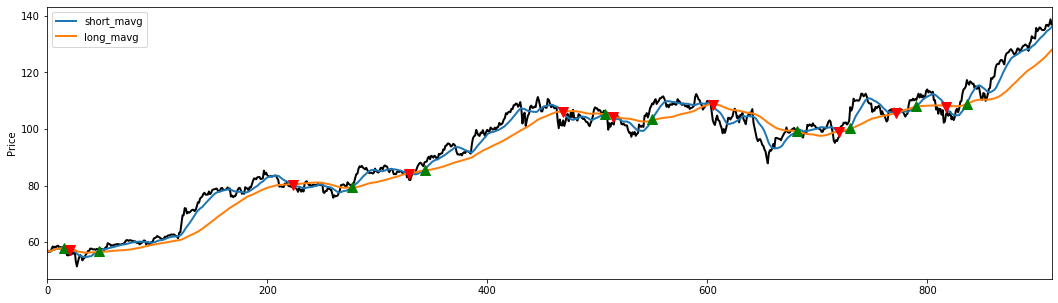

In [187]:
# Import `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure(figsize=(18, 5))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price')

# Plot the closing price
df_jpm['predicted_close_price'].plot(ax=ax1, color='k', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='g')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='r')
         
# Show the plot
plt.show()

### Lasso

In [189]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [190]:
df_temp_new = df_jpm.copy()

In [192]:
df_temp_new.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MktRF,SMB,HML,RF,RMW,CMA,SMB_5,yest_close,stock_return,log_return,price,predicted close price,predicted_close_price
0,2016-05-18,61.700001,64.169998,61.689999,64.040001,57.172466,24007100,0.10,0.10,0.83,0.001,-1.34,-0.65,0.14,55.047691,0.038599,0.000000,0.038599,57.172466,57.172466
1,2016-05-19,63.529999,64.220001,62.900002,63.389999,56.592175,16076200,-0.33,-0.32,-0.30,0.001,0.39,-0.01,-0.31,57.172466,-0.010150,-0.010202,0.028449,56.592175,56.592175
2,2016-05-20,63.860001,64.190002,63.369999,63.509998,56.699303,11862000,0.75,0.90,-0.30,0.001,-0.39,-0.38,0.84,56.592175,0.001893,0.001891,0.030342,56.699303,56.699303
3,2016-05-23,63.450001,63.869999,63.160000,63.459999,56.654667,9347500,-0.18,0.26,-0.32,0.001,-0.21,0.08,0.24,56.699303,-0.000787,-0.000788,0.029555,56.654667,56.654667
4,2016-05-24,63.939999,64.769997,63.810001,64.540001,57.618855,13839400,1.43,0.68,-0.34,0.001,-0.10,-0.39,0.61,56.654667,0.017019,0.016875,0.046573,57.618855,57.618855


In [215]:
X_train, X_test, y_train, y_test = train_test_split(
    df_temp_new.drop(labels=['stock_return','Date','predicted close price','log_return','predicted_close_price'], axis=1),
    df_temp_new['stock_return'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape


((639, 15), (275, 15))

In [216]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
sel_.fit(scaler.transform(X_train, y_train))

StandardScaler(copy=True, with_mean=True, with_std=True)

### Sharp Ratio


In [222]:
window_new = 852

In [226]:
# Returns of trading strategy
returns = df_comb['stock_return']
# Sharpe ratio
sharpe_ratio = np.sqrt(window_new) * (returns.mean() / returns.std())
print(sharpe_ratio)

2.103614783237555


In [242]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['jpm'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(df_jpm['predicted_close_price'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(df_jpm['predicted_close_price'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(df_jpm['predicted_close_price'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.head())

   jpm  holdings      cash     total  returns
0  0.0       0.0  100000.0  100000.0      NaN
1  0.0       0.0  100000.0  100000.0      0.0
2  0.0       0.0  100000.0  100000.0      0.0
3  0.0       0.0  100000.0  100000.0      0.0
4  0.0       0.0  100000.0  100000.0      0.0


In [243]:
portfolio

,jpm,holdings,cash,total,returns
0,0.0000,0.0000,100000.0000,100000.0000,NaN
1,0.0000,0.0000,100000.0000,100000.0000,0.000000
2,0.0000,0.0000,100000.0000,100000.0000,0.000000
3,0.0000,0.0000,100000.0000,100000.0000,0.000000
4,0.0000,0.0000,100000.0000,100000.0000,0.000000
5,0.0000,0.0000,100000.0000,100000.0000,0.000000
6,0.0000,0.0000,100000.0000,100000.0000,0.000000
7,0.0000,0.0000,100000.0000,100000.0000,0.000000
8,0.0000,0.0000,100000.0000,100000.0000,0.000000
9,0.0000,0.0000,100000.0000,100000.0000,0.000000
